In [243]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scikeras.wrappers import KerasClassifier

irisData = pd.read_csv('irisData/iris_dataset.csv')

In [244]:
irisData.head()  

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [245]:
irisData.shape
irisData["species"].value_counts()
irisData.isnull().sum().sum() # sum of the sums, only one shows the missing sums for each category

irisData.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


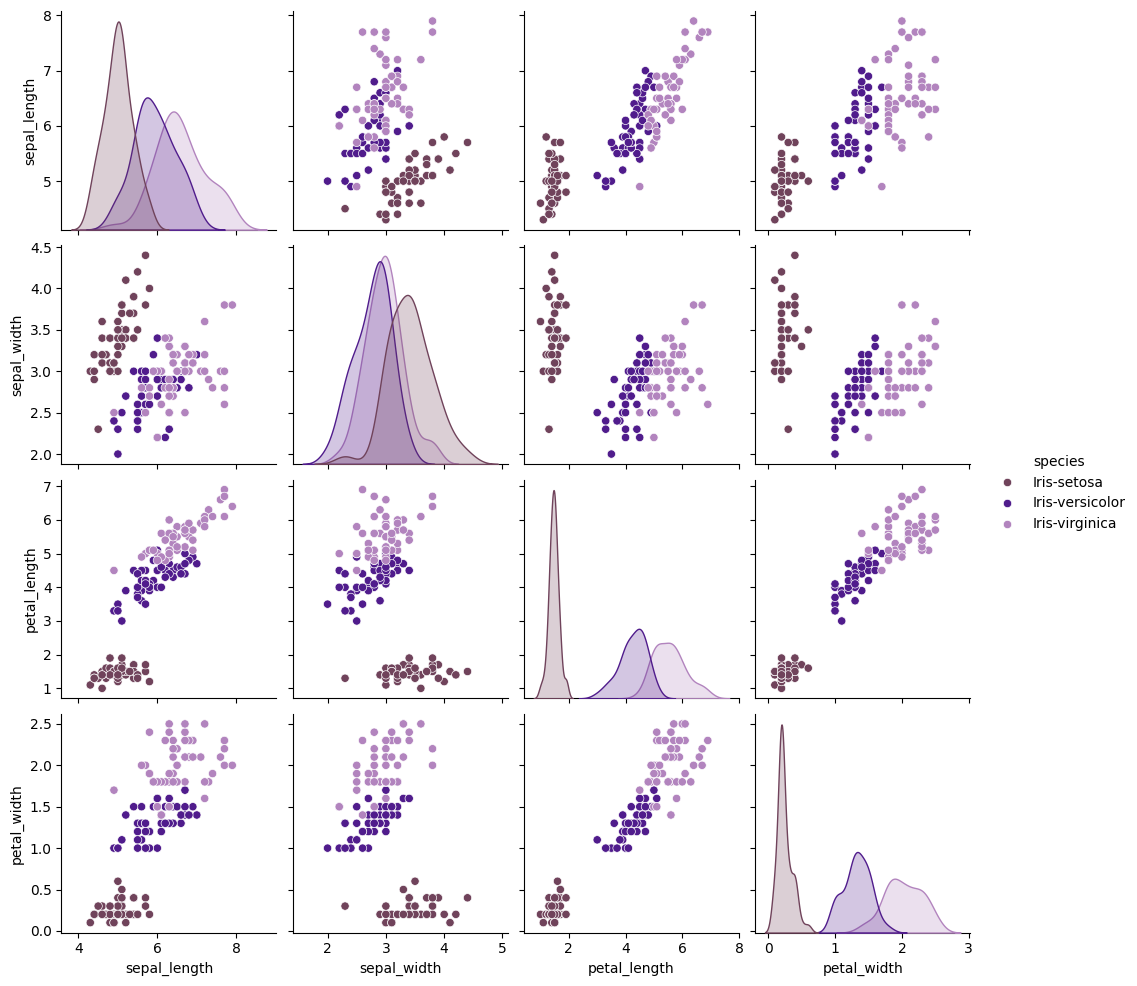

In [261]:
palette = ["#70435B", '#501C8C', '#B284BE']
sns.pairplot(irisData, hue="species", palette = palette)

notes for me;
setosa has a high sepal width and a low sepal length; virginica has a low sepal width and a high sepal length; versicolor is typically somewhere in between the two

length goes from setosa --> versicolor --> virginica (shortest to longest)

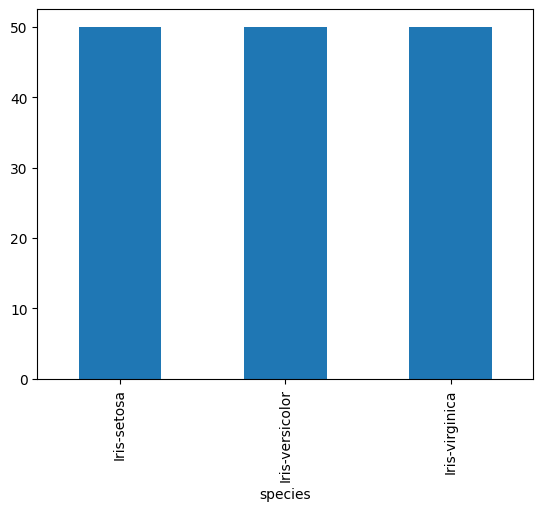

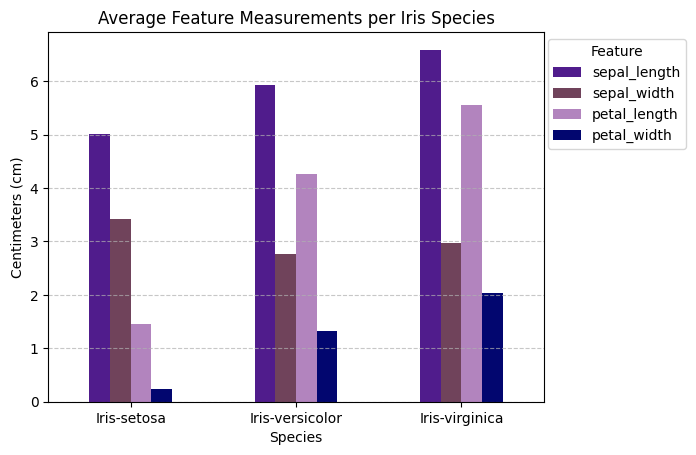

In [262]:
irisData['species'].value_counts().plot(kind='bar') # note; each species has 50 data points in this set

colors = ['#501C8C', "#70435B", "#B284BE", '#02066F']
customCmap = ListedColormap(colors)
meanValues = irisData.groupby('species').mean()
meanValues.plot(kind='bar', cmap = customCmap)

plt.title('Average Feature Measurements per Iris Species')
plt.xlabel('Species')
plt.xticks(rotation=0)
plt.ylabel('Centimeters (cm)')
plt.legend(title='Feature', bbox_to_anchor=(1.3, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)

In [248]:
# encoding because the class names aren't numbers :sweat:
irisData.sample(10)
irisEncoded = pd.get_dummies(irisData, columns=['species'], dtype=int)
irisEncoded.head()

,sepal_length,sepal_width,petal_length,petal_width,species_Iris-setosa,species_Iris-versicolor,species_Iris-virginica
0,5.1,3.5,1.4,0.2,1,0,0
1,4.9,3.0,1.4,0.2,1,0,0
2,4.7,3.2,1.3,0.2,1,0,0
3,4.6,3.1,1.5,0.2,1,0,0
4,5.0,3.6,1.4,0.2,1,0,0


note to self; using one hot encoding can be better than using label encoding to avoid bias!

last summer, i used label encoding for my machine learning project (yap session).. i wonder if that messed with the accuracy of the multiple linear regression model

In [249]:
featureColumns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
labelColumns = ['species_Iris-setosa', 'species_Iris-versicolor', 'species_Iris-virginica']
x = irisEncoded[featureColumns].values
y = irisEncoded[labelColumns].values

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=42) #random state = the shuffling
scaler = StandardScaler() # standardization here vs using z score
xTrain = scaler.fit_transform(xTrain)
xTest = scaler.transform(xTest)

In [250]:
def createModel(learningRate = 0.01): # wires the neural network
    model = keras.Sequential([
        keras.layers.Input(shape=(4,)), # four input descriptors tuple
        keras.layers.Dense(16, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.2), # prevents overfitting
        keras.layers.Dense(8, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(3, activation='softmax') # three species options
    ])

    # model.compile(
    #    loss = 'categorical_crossentropy',
    #    metrics = ['accuracy']
    #)

    return model

note to self; it's more common to start with more neurons in earlier layers. relu = rectified linear unit, which sets negative values to 0 and helps the model learn quickly without slowing anything down

also, drop-off randomly turns off 20% of neurons to fight against overfit
and softmax converts the output into 3 probability values that sum to 1

high probability = the models chosen species

In [251]:
# adding gridsearchcv to try and increase the accuracy

#kerasCLF = KerasClassifier(
#    model = createModel,
#    optimizer = keras.optimizers.Adam,
#    optimizer__learning_rate = 0.01,
#    verbose = 0
#)

#paramGrid = {
#    'optimizer__learning_rate': [0.001, 0.01, 0.1],
#    'batch_size': [4, 8, 16],
#    'epochs': [50],
#}

#grid = GridSearchCV(estimator = kerasCLF, param_grid = paramGrid, cv = 3, verbose = 1)

#gridResult = grid.fit(xTrain, yTrain)
#print("Training done!")

#print("Best parameters found:", gridResult.best_params_)
#testAcc = grid.score(xTest, yTest)
#print(f"\nGridSearchCV Test Accuracy: {testAcc:.4f}")

In [252]:
learningRate = 0.01
model = createModel(learningRate) # creates a model via the neural network
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=learningRate), # adaptive moment estimation
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

earlyStopping = keras.callbacks.EarlyStopping( # stop training when loss stops improving for 10 rounds
    monitor = 'val_loss', patience = 10, restore_best_weights = True
)

#note; learning_rate and restore_best_weights are NOT user-made variables

In [253]:
history = model.fit(
    xTrain, yTrain,
    validation_data = (xTest, yTest),
    epochs = 50, # limit to 50 training rounds
    batch_size = 16, # model updates every 16 samples
    callbacks = [earlyStopping],
    verbose = 1
)

# note; validation_data, val_loss, and batch_size are NOT user-made variables

print("Training done!")

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.4597 - loss: 1.2087 - val_accuracy: 0.8000 - val_loss: 0.9251
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7706 - loss: 0.6892 - val_accuracy: 0.8333 - val_loss: 0.7627
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7504 - loss: 0.5962 - val_accuracy: 0.8333 - val_loss: 0.6355
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7631 - loss: 0.4993 - val_accuracy: 0.8333 - val_loss: 0.5465
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8424 - loss: 0.3719 - val_accuracy: 0.8667 - val_loss: 0.4747
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9124 - loss: 0.2867 - val_accuracy: 0.8667 - val_loss: 0.4199
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9001 - loss: 0.2662 - val_accuracy: 0.8667 - val_loss: 0.3740
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9123 - loss: 0.2717 - val_accuracy: 0.9000 - val_loss: 0.3086


In [254]:
print("\nEvaluating on the test data...") # final model test
testLoss, testAcc = model.evaluate(xTest, yTest, verbose = 0)
print(f"Test Accuracy: {testAcc:.4f}")


Evaluating on the test data...
Test Accuracy: 1.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step

Confusion Matrix:
[[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]


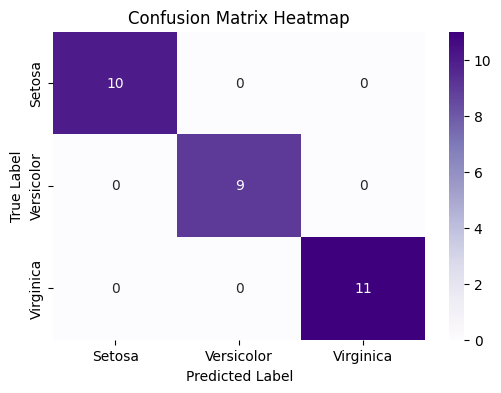

In [255]:
# adding a confusion matrix to see how the model did

yPredProbs = model.predict(xTest)
yPredClasses = np.argmax(yPredProbs, axis = 1)
yTrueClasses = np.argmax(yTest, axis = 1)

cm = confusion_matrix(yTrueClasses, yPredClasses)

print("\nConfusion Matrix:")
print(cm)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap= "Purples",
            xticklabels = ['Setosa', 'Versicolor', 'Virginica'],
            yticklabels = ['Setosa', 'Versicolor', 'Virginica'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

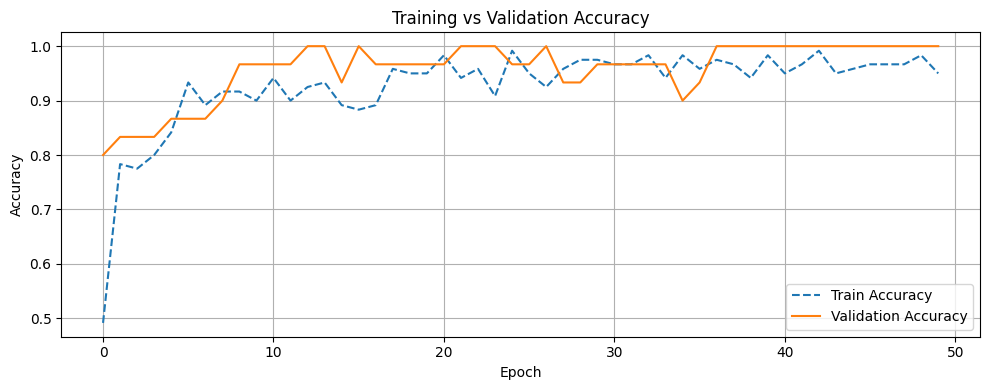

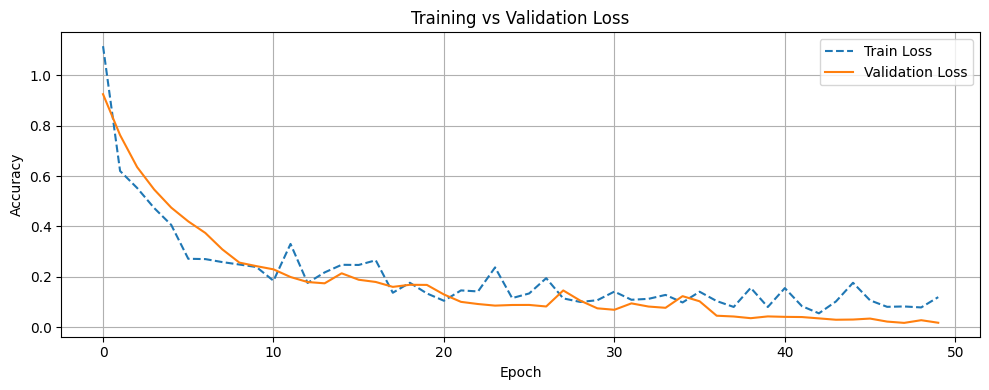

In [256]:
# graphs for accuracy and loss

# accuracy
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'], label='Train Accuracy', linestyle='--')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss', linestyle='--')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [257]:
# bias checking w class-wise accuracy
classWiseAccuracy = cm.diagonal() / cm.sum(axis = 1)
for i, acc in enumerate(classWiseAccuracy):
    print(f"Accuracy for Class {i}: {acc:.2f}")

# bias checking w a classifcation report
print("\nClassification Report:")
print(classification_report(yTrueClasses, yPredClasses, target_names=[
    "Iris-setosa", "Iris-versicolor", "Iris-virginica"
]))

# note; target_names is NOT a user-made variable

Accuracy for Class 0: 1.00
Accuracy for Class 1: 1.00
Accuracy for Class 2: 1.00

Classification Report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      1.00      1.00         9
 Iris-virginica       1.00      1.00      1.00        11

       accuracy                           1.00        30
      macro avg       1.00      1.00      1.00        30
   weighted avg       1.00      1.00      1.00        30

